## Policy Evaluation

Let's try to evaluate a policy using Monte Carlo and TD(0).

The world and the policy are the following:

<img src="http://www.cs.upc.edu/~mmartin/Grid+world.jpg" width="350">


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Define the state matrix
state_matrix = np.zeros((3,4))
state_matrix[0, 3] = 1
state_matrix[1, 3] = 1
state_matrix[1, 1] = -1
print("State Matrix:")
print(state_matrix)


State Matrix:
[[ 0.  0.  0.  1.]
 [ 0. -1.  0.  1.]
 [ 0.  0.  0.  0.]]


Reward Matrix:
[[-0.04 -0.04 -0.04  1.  ]
 [-0.04 -0.04 -0.04 -1.  ]
 [-0.04 -0.04 -0.04 -0.04]]


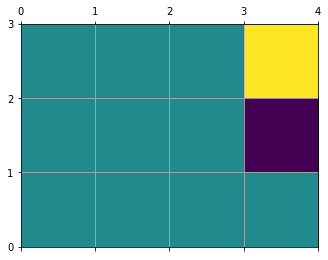

In [2]:
#Define the reward matrix
reward_matrix = np.full((3,4), -0.04)
reward_matrix[0, 3] = 1
reward_matrix[1, 3] = -1
print("Reward Matrix:")
print(reward_matrix)
plt.matshow(reward_matrix,extent=[0, 4, 0, 3])
plt.grid()
plt.show()

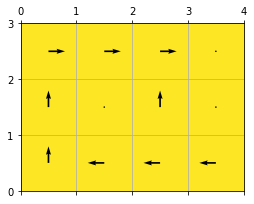

In [3]:
def print_policy(policy_matrix2, V=np.array([]),lstates=[]):
    policy_matrix = policy_matrix2[::-1]
    shape = policy_matrix.shape
    U=np.zeros(policy_matrix.shape)
    R=np.zeros(policy_matrix.shape)
    for row in range(shape[0]):
        for col in range(shape[1]):
            if(policy_matrix[row,col] == -1): 
                U[row,col]=0    
                R[row,col]=0  
            elif(policy_matrix[row,col] == 0): 
                U[row,col]=0    
                R[row,col]=1 
                #policy_string += " ^  "
            elif(policy_matrix[row,col] == 1): 
                U[row,col]=1   
                R[row,col]=0 
                #policy_string += " >  "
            elif(policy_matrix[row,col] == 2): 
                U[row,col]=0    
                R[row,col]=-1 
                #policy_string += " v  "           
            elif(policy_matrix[row,col] == 3):
                U[row,col]=-1   
                R[row,col]=0                 
                #policy_string += " <  "
            elif(np.isnan(policy_matrix[row,col])): 
                U[row,col]=0    
                R[row,col]=0  
                #policy_string += " #  "
    plt.rcParams['figure.figsize'] = (4,3)
    if V.size==0:
        V=np.ones(policy_matrix.shape)
        for x in lstates:
            V[x[0],x[1]]=0.7
        plt.matshow(V,extent=[0, 4, 0, 3],vmin=0, vmax=1)
    else:
        plt.matshow(V,extent=[0, 4, 0, 3])
    plt.grid()
    X, Y = np.meshgrid(np.arange(0.5, 4.5, 1), np.arange(0.5, 3.5, 1))
    Q = plt.quiver(X, Y,U,R)

    plt.show()

policy_matrix = np.array([[1,      1,  1,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      3,  3,   3]])

print_policy(policy_matrix)

In [4]:
transition_matrix = np.array([[0.8, 0.1, 0.0, 0.1],
                              [0.1, 0.8, 0.1, 0.0],
                              [0.0, 0.1, 0.8, 0.1],
                              [0.1, 0.0, 0.1, 0.8]])


In [5]:
gamma = 0.999

def execute_action(s1,a):
    a=np.random.choice([0,1,2,3],p=transition_matrix[int(a)])    
    row = s1[0]
    col = s1[1]
    if(a == 0): 
        new_col = col + 0
        new_row =row - 1
    elif(a == 1): 
        new_col =col + 1
        new_row =row + 0
    elif(a == 2): 
        new_col =col + 0
        new_row =row + 1      
    elif(a == 3):
        new_col =col - 1
        new_row =row + 0              
    new_col = np.clip(new_col, 0, 3)
    new_row = np.clip(new_row, 0, 2)
    if state_matrix[new_row,new_col]==-1: 
        new_col = col
        new_row = row
    return (new_row, new_col), reward_matrix[new_row,new_col],a


In [7]:
def gen_trial():
    lS=[]
    lr=[]
    la=[]
    valid_start_states = [(r,c) for c in range(4) for r in range(3) if state_matrix[r][c]==0]
    state = valid_start_states[np.random.choice(len(valid_start_states))]
    #print_policy(policy_matrix,lstates=[state])
    while state_matrix[state]!=1:
        lS.append(state)
        state,r,a=execute_action(state,policy_matrix[state])
        lr.append(r)
        la.append(a)
        #print_policy(policy_matrix,lstates=[state])
    return lS,lr,la
gen_trial()

([(2, 1), (2, 0), (1, 0), (0, 0), (0, 1), (0, 2)],
 [-0.04, -0.04, -0.04, -0.04, -0.04, 1.0],
 [3, 0, 0, 1, 1, 1])

In [6]:
def sum_returns(lr,i):
    s=0
    g=1
    for r in range(i,len(lr)):
        s = s+ lr[r]*g
        g = g*gamma
    return s


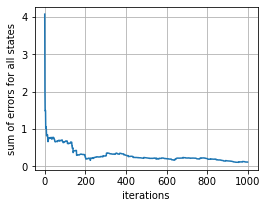

array([[0.84101971, 0.90423289, 0.95061204, 0.        ],
       [0.78639187, 0.        , 0.71601407, 0.        ],
       [0.72685707, 0.67396404, 0.63786866, 0.39174654]])

In [8]:
# From previous notebooks
TrueV =[[0.84881226, 0.90630541, 0.95748948, 0.],
        [0.797764, 0., 0.69906187, 0.],
        [0.7404234,  0.6895106,  0.64536512, 0.42192624]]

# Exact Monte-Carlo First Visit
lerror=[]
ntrial = 1000
V = np.zeros((3,4))
N = np.zeros((3,4))
for i in range(ntrial):
    lS,lr,la = gen_trial()
    visited = []
    for i,s in enumerate(lS):
        if s not in visited:
            visited.append(s)
            N[s] = N[s]+1
            alpha=1/N[s]
            V[s]=V[s]+alpha*(sum_returns(lr,i)-V[s])
    lerror.append(np.sum(np.abs(TrueV - V)))

plt.plot(lerror)
plt.grid()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()
V

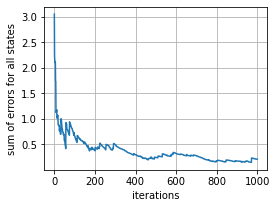

array([[0.83308153, 0.89249583, 0.95058926, 0.        ],
       [0.78163478, 0.        , 0.67081435, 0.        ],
       [0.72411334, 0.67797964, 0.63474862, 0.3342545 ]])

In [9]:
# Exact Monte-Carlo Every Visit
lerror=[]
ntrial = 1000
V = np.zeros((3,4))
N = np.zeros((3,4))
for i in range(ntrial):
    lS,lr,la = gen_trial()
    for i,s in enumerate(lS):
            N[s] = N[s]+1
            alpha=1/N[s]
            V[s]=V[s]+alpha*(sum_returns(lr,i)-V[s])
    lerror.append(np.sum(np.abs(TrueV - V)))

plt.plot(lerror)
plt.grid()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()
V

[[0.87309459 0.92909115 0.97631247 0.        ]
 [0.81701781 0.         0.75674276 0.        ]
 [0.77323628 0.72565935 0.69347157 0.5423808 ]] 0.1
[[0.87108487 0.93077993 0.97761849 0.        ]
 [0.81818466 0.         0.75931705 0.        ]
 [0.75672798 0.71829599 0.67029706 0.49000201]] 0.05
[[0.85962786 0.92183972 0.96061001 0.        ]
 [0.81905112 0.         0.50147047 0.        ]
 [0.74102555 0.66783209 0.56156055 0.23542705]] 0.01


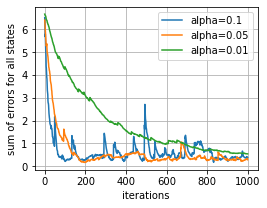

In [12]:
# Alpha Monte-Carlo
for alpha in [0.1,0.05,0.01]:
    lerror=[]
    ntrial = 1000
    V = np.zeros((3,4))
    for i in range(ntrial):
        lS,lr,la = gen_trial()
        visited = []
        for i,s in enumerate(lS):
            if s not in visited:
                visited.append(s)
                V[s]=V[s]+alpha*(sum_returns(lr,i)-V[s])
        lerror.append(np.sum(np.abs(TrueV - V)))

    plt.plot(lerror, label=f'alpha={alpha}')
    print(V,alpha)
plt.grid()
plt.legend()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()


[[0.84126412 0.86627844 0.9410787  0.        ]
 [0.82120759 0.         0.75233894 0.        ]
 [0.78417597 0.73437305 0.69415384 0.42900011]] 0.2
[[0.84674246 0.90345411 0.96429626 0.        ]
 [0.8125254  0.         0.66043191 0.        ]
 [0.7649926  0.71658732 0.68147459 0.56980536]] 0.1
[[0.87779321 0.92294548 0.97574991 0.        ]
 [0.83299321 0.         0.89130405 0.        ]
 [0.76690105 0.71078693 0.66741747 0.37277098]] 0.05


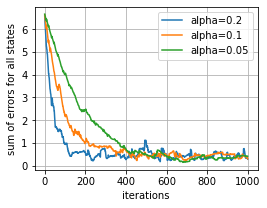

In [13]:
# Alpha Temporal Differences
for alpha in [0.2,0.1,0.05]:
    lerror=[]
    ntrial = 1000
    V = np.zeros((3,4))
    for i in range(ntrial):
        lS,lr,la = gen_trial()
        for i,s in enumerate(lS):
            visited.append(s)
            if i+1<len(lS):
                V[s]=V[s]+alpha*(lr[i]+gamma*V[lS[i+1]]-V[s])
            else:
                V[s]=V[s]+alpha*(lr[i]-V[s])
        lerror.append(np.sum(np.abs(TrueV - V)))

    plt.plot(lerror, label=f'alpha={alpha}')
    print(V,alpha)
plt.grid()
plt.legend()
plt.ylabel('sum of errors for all states')
plt.xlabel('iterations')
plt.show()
